In [1107]:
# a good reference
# https://ruder.io/optimizing-gradient-descent/

In [1108]:
# import Pkg; Pkg.add("Interpolations")

In [1109]:
using Plots
using DataFrames
using CSV
using Tables
using Interpolations
using Statistics

# Generate data
* either generate the data
* OR read it from csv

In [1110]:
function get_data(read_file = false)
    filename = "mydata.csv"
    version = 1
    if read_file==false #isfile(filename)==false
        println("generating data")
        ee = 0.0
        x = collect(-1-ee:0.01:1+ee)
        y = x.^2;
        if version == 0
            println("Do nothing special")
        elseif  version ==1
            y += y.*rand(Float32, size(x)[1])*0.5;
            y += y.*sin.(-0.3.+ pi*2*x*4)*0.25
            y += rand(Float32, size(x)[1])*0.05
        elseif  version ==2
        
            # y += y.*rand(Float32, size(x)[1])*0.5;
            y += y.*sin.(pi*2*x*4)*0.25
        end
        df = DataFrame((x=x, y  =y));
        CSV.write(filename, df)
    else
        println("Reading file")
        df = DataFrame(CSV.File(filename));
        x = df[!,"x"];
        y = df[!, "y"];
    end
    return x,y
end

get_data (generic function with 2 methods)

Reading file


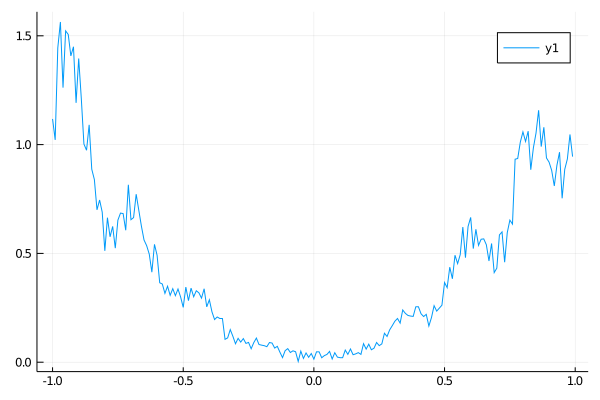

In [1111]:
xpoints, ypoints = get_data(true)
plot(xpoints,ypoints)


In [1112]:
# x=1:0.25:5
# y = log.(x);
# x2 = 1:0.1:5
# interp_linear = LinearInterpolation(x,y);
# y2 = interp_linear.(x2);
# size(y2)
# scatter(x,y, label = "y")
# scatter!(x2,y2, label = "y2")


n = size(y2)[1]
n

In [1113]:
last_n = 5
mean(y2[n-last_n:n])

1.5573124399817324

In [1114]:
function mean_of_last_items(loss_values, last_n = 5)
    # get the average of the last 5 items in the list
    n = size(loss_values)[1]
    if n<5
        return 1
    else
        return mean(loss_values[n-last_n:n])
    end
end

mean_of_last_items (generic function with 2 methods)

In [1115]:
function numerical_derivative(f, x, dx=0.00001, min =-1, max = 1)
    if (x-dx) <min
        x = min+dx
    end
    if (x+dx)>max
        x = max-dx
    end
    derivative = (f(x+dx) - f(x-dx))/(2*dx) 
    return derivative 
end 

numerical_derivative (generic function with 4 methods)

In [1116]:
function x_still_changing(x_values)
    if length(x_values)<6
        return true
    end
    m = mean_of_last_items(x_values)
    v = last(x_values)
    diff = abs(m-v)
    if diff<1e-4
        return false
    else
        return true
    end
end

x_still_changing (generic function with 1 method)

In [1117]:
function make_inter_function(x,y, xmin=-1, xmax=1)
    interp_linear = LinearInterpolation(x,y);
    xmax = maximum(x)
    xmin = minimum(x)
    f = function (x)
        if x<xmin
            x = xmin
        end
        if x>xmax
            x = xmax
        end
        return interp_linear(x)
  
        
    end
    return f
end

make_inter_function (generic function with 3 methods)

In [1118]:
f = make_inter_function(xpoints,ypoints);

In [1119]:
f(0.1), f(2),f(-2)

(0.020860836636402296, 0.9448044713956257, 1.1178633284345416)

In [1120]:
function plot_optimization_results(xs, f, name = "")
    ys = f.(xs);
    scatter(xs,ys, lw = 4, title = "Evaluted points values a function of iteration #.\n Using $name")
    plot!(xs,ys, label = "Path")
    plot!(xpoints,ypoints, label = "True", legend = :outertopleft)
end

plot_optimization_results (generic function with 2 methods)

In [1121]:
function find_a_min_grad(funct_input, start = 0.95)
    x_i = start 
    step = 1e-2
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)     
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end     
        x_delta = -dydx*step # step in the negative gradient
        x_i = x_i+x_delta      
        push!(x_list, x_i)
    end
    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_grad (generic function with 2 methods)

In [1122]:
x, xs = find_a_min_grad(f);

Found a min at 1.0912101287403544. Iteration 8


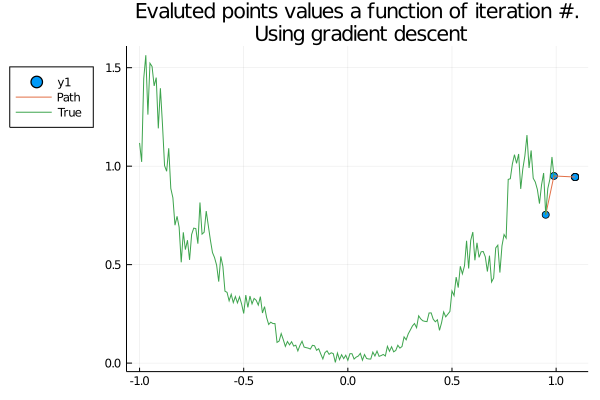

In [1123]:
plot_optimization_results(xs, f,  "gradient descent")

In [1124]:
function find_a_min_momentum(funct_input, start = 0.95)
    x_i = start 
    # println("argmin is $idx with x value of $x_i")
    step = 1e-2
    m_t = 0
    m_t_minus_1 = 0
    beta = 0.5
    eps_ = 1e-7
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)
        # println("$x_i and $i")
        # get the gradient
        # dydx = f_dydx(x_i)
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        m_t = beta*m_t_minus_1+(1-beta)*dydx
        x_delta = -m_t*step # step in the negative gradient
        x_i = x_i+x_delta
        m_t_minus_1 = m_t
        push!(x_list, x_i)
    end
    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_momentum (generic function with 2 methods)

Found a min at 1.2239415130234368. Iteration 38


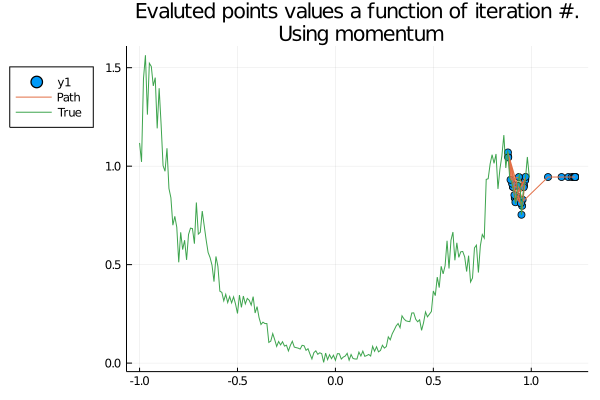

In [1125]:
# @time x, xs = find_a_min_momentum(f);
x, xs = find_a_min_momentum(f);

plot_optimization_results(xs, f, "momentum")


In [1126]:
function find_a_min_rmsp(funct_input, start = 0.95)   
    x_i = start 
    step = 1e-2 # basically the learning rate. 
    v_t = 0
    v_t_minus_1 = 0
    beta = 0.9
    eps_ = 1e-7
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)
        # get the gradient
        # dydx = f_dydx(x_i)
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        # m_t = beta*m_t_minus_1+(1-beta)*dydx
        v_t = beta*v_t_minus_1 +(1-beta)*dydx^2
        update_term = 1/(sqrt(v_t)+1e-9)*dydx
        x_delta = -update_term*step # step in the negative gradient
        x_i = x_i+x_delta
        v_t_minus_1 = v_t
        push!(x_list, x_i)

    end

    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_rmsp (generic function with 2 methods)

Found a min at 1.0113015065634863. Iteration 8


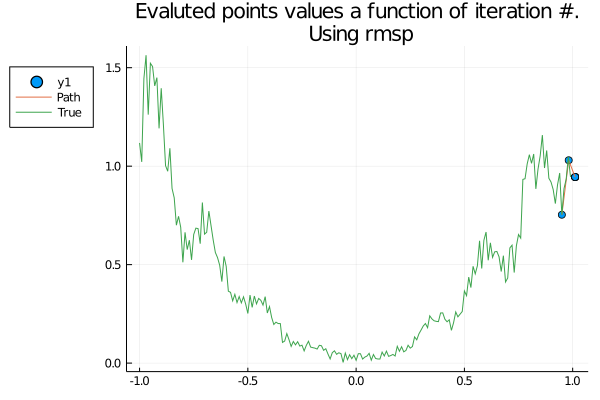

In [1127]:
x, xs = find_a_min_rmsp(f);
plot_optimization_results(xs, f, "rmsp")


In [1128]:
function find_a_min_adam(funct_input, start = 0.95)   
    x_i = start # trial_x[idx] # x sub i 
    step = 1e-2 # basically the learning rate. 
    v_t = 0
    v_t_minus_1 = 0
    m_t = 0
    m_t_minus_1 = 0
    beta_1 = 0.99 # for the momentum m_t 
    beta_2 = 0.99 # for the rmsprop v_t
    eps_ = 1e-7
    x_list = []
    for i in range(1,length = 3000)
        # get the gradient
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        m_t = beta_1*m_t_minus_1+(1-beta_1)*dydx
        v_t = beta_2*v_t_minus_1 +(1-beta_2)*dydx^2
        
        m_t_hat = m_t/(1-beta_1)
        v_t_hat = v_t/(1-beta_2)
       

        update_term = m_t_hat/(sqrt(v_t_hat)+1e-9)*dydx
        x_delta = -update_term*step # step in the negative gradient
        x_i = x_i+x_delta
        v_t_minus_1 = v_t
        m_t_minus_1 = m_t

        push!(x_list, x_i)


    end

    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_adam (generic function with 2 methods)

Found a min at 0.03819039406206483. Iteration 85


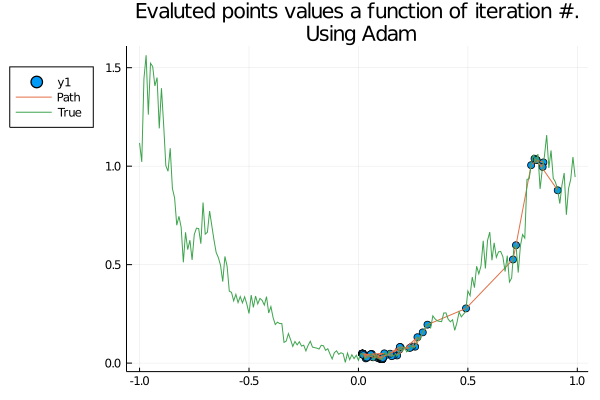

In [1129]:
x, xs = find_a_min_adam(f);
plot_optimization_results(xs, f, "Adam")